# Calculate Z-scores for players

This takes the list of players that we're trying to calculate scores for, and creates z-scores for players with an arbitrarily chosen minimum innings (for pitchers) or plate appearances (for hitters).

Notes for this year's sheet:

- Z-score avg/stdev calculated using minimum IP (70) or PA (35) stats for batting and pitching.
- Reliever value was artificially decremented as usual since they're normally over-inflated value-wise. Multiplied by (project innings) / (90th pctile of projected innings), capped at 1.0.

In [1]:
import pandas as pd
import numpy as np
import os
import sqlalchemy
import psycopg2
import seaborn as sb
import requests

# arbitrarily high max view columns
pd.options.display.max_columns = 150
pd.options.display.max_rows = 200

/Users/zach/Library/Python/3.7/lib/python/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## SqlAlchemy Connection Information

These are used to get and return a connection to the postgres DB so that we can query for player stats and write them back to the table.

In [2]:
# connection information for the database
POSTGRES_USER = os.environ.get("POSTGRES_USER")
POSTGRES_PASSWORD = os.environ.get("POSTGRES_PASSWORD")
POSTGRES_IP = "192.168.0.118"
POSTGRES_PORT = 5432
POSTGRES_DB = "postgres"

def get_sqlalchemy_engine():
    """
    Create and return a SQLAlchemy engine for inserting into postgres.
    """
    # ## Write Information Back to Database
    #
    return sqlalchemy.create_engine(
        "postgres://{user}:{password}@{host}:{port}/{db}".format(
            user=POSTGRES_USER,
            password=POSTGRES_PASSWORD,
            host=POSTGRES_IP,
            port=POSTGRES_PORT,
            db=POSTGRES_DB,
        )
    )

In [3]:
# create a connection and read in pitchers data
engine = get_sqlalchemy_engine()
conn = engine.connect()

## Calculate Z-Scores

For each of the players, we calculate a z-score based on how they compare to the rest of the league. There are several columns that we want to do this for.

- For each z-score, there is an arbitrary minimum set to inflate the league average away from non-full-time players.
- After each is totaled, the z-scores are totaled and then z-scored again to make a single number. This is done so that we can compare pitchers and batters into the same chart.

In [4]:
# read in information from postgres
dfp = pd.read_sql("select * from fantasy.pitchers_projections_depth_charts where ip > 0.0", conn)
dfb = pd.read_sql("select *from fantasy.batters_projections_depth_charts", conn)
# dfpa = pd.read_sql("select * from fantasy.pitchers_statcast_actuals", conn)
# dfpa.columns = [x.lower() for x in dfpa.columns]
# dfba = pd.read_sql("select * from fantasy.batters_statcast_actuals", conn)
# dfpa.fillna(0, inplace=True)
# dfba.fillna(0, inplace=True)
print()

In [5]:
# create any calculated columns necessary
dfb['k_pct'] = (dfb['so'] / dfb['ab']).round(2)
dfb['rc'] = (dfb['ab'] * dfb['obp'] * dfb['slg']).round(2)
# dfba['k_pct'] = (dfb['so'] / dfb['ab']).round(2)
# dfba['rc'] = (dfba['ab'] * dfba['obp'] * dfba['slg']).round(2)
# dfpa['hr9'] = (dfpa['hr'] / dfpa['ip'] * 9.0).round(2)

# quality starts metric from here:
# https://yourfantasyjoe.blogspot.com/2010/02/projecting-quality-starts.html
# xQS = GS * (.4650115 - (ERA * .0872381) + ((IP/GS) * .0746775))
dfp['qs'] = (dfp['gs'] * (0.4650115 - (dfp['era'] * 0.0872381) + ((dfp['ip']/dfp['gs']) * .0746775))).round(2)
dfp.fillna(value={'qs': 0.0}, inplace=True)
print()

In [6]:
# thresholds for batters and pitchers
MINIMUM_INNINGS_PITCHED = 100
MINIMUM_INNINGS_PITCHED_ACTUALS = 20.0
MINIMUM_PLATE_APPEARANCES = 180
MINIMUM_PLATE_APPEARANCES_ACTUALS = 120
min_pa = dfb['pa'] > MINIMUM_PLATE_APPEARANCES
# min_pa_act = dfba['pa'] > MINIMUM_PLATE_APPEARANCES_ACTUALS
min_ip = dfp['ip'] > MINIMUM_INNINGS_PITCHED
# min_ip_act = dfpa['ip'] > MINIMUM_INNINGS_PITCHED_ACTUALS

# dict of columns that we want to calculate z-scores for
# +1 means more is better, -1 means negative is better
dfb_score_cols = {
    "pa": {"dir": 1, "weight": 1.3}, 
    "k_pct": {"dir": -1, "weight": 1.0},
    "hr": {"dir": 1, "weight": 0.9},
    "rc": {"dir": 1, "weight": 1.4},
    "woba": {"dir": 1, "weight": 1.3},
    "slg": {"dir": 1, "weight": 1.0},
    "adp": {"dir": -1, "weight": 0.3}
}
dfp_score_cols = {
    "ip": {"dir": 1, "weight": 1.3},
    "era": {"dir": -1, "weight": 1.0},
    "hr": {"dir": -1, "weight": 0.9},
    "so": {"dir": 1, "weight": 1.0},
    "whip": {"dir": -1, "weight": 1.5},
    "k-9": {"dir": 1, "weight": 1.3},
    "qs": {"dir": 1, "weight": 1.0},
    "gs": {"dir": 1, "weight": 0.35}
}
dfba_score_cols = {
    "pa": {"dir": 1, "weight": 2.15},
    "k_pct": {"dir": -1, "weight": 0.4},
    "hr": {"dir": 1, "weight": 1.25},
    "rc": {"dir": 1, "weight": 1.12},
    "ops": {"dir": 1, "weight": 1.015},
    "slg": {"dir": 1, "weight": 1.15}
}
dfpa_score_cols = {
    "ip": {"dir": 1, "weight": 2.0},
    "era": {"dir": -1, "weight": 1.0},
    "hr9": {"dir": -1, "weight": 0.9},
    "so9": {"dir": 1, "weight": 1.0},
    "whip": {"dir": -1, "weight": 1.5},
    "str": {"dir": 1, "weight": 1.3},
    "gs": {"dir": 1, "weight": 0.35}
}
dfb_weight = 1.0
dfba_weight = 0.85
dfp_weight = 0.88
dfpa_weight = 0.82

# get all of the score columns for maximum z-scoring
dfb_score_col_names = [x + "_score" for x in dfb_score_cols.keys()]
# dfba_score_col_names = [x + "_score" for x in dfba_score_cols.keys()]
dfp_score_col_names = [x + "_score" for x in dfp_score_cols.keys()]
# dfpa_score_col_names = [x + "_score" for x in dfpa_score_cols.keys()]

# filter out unqualifieds
# dfba = dfba[min_pa_act]
# dfpa = dfpa[min_ip_act]

In [7]:
# only mean and stdev are filtered by minimums, so that way the player's actual
# projections are still counted normally.

# batter scores
for col in dfb_score_cols.keys():
    col_score = col + "_score"
    dfb[col_score] = (
        (dfb[col] - dfb[col][min_pa].mean()) / dfb[col][min_pa].std(ddof=0)
        * dfb_score_cols[col]["dir"]
        * dfb_score_cols[col]["weight"]
    ).round(3)

# batter actuals
# for col in dfba_score_cols.keys():
#     col_score = col + "_score"
#     dfba[col_score] = (
#         (dfba[col] - dfba[col][min_pa_act].mean()) / dfba[col][min_pa_act].std(ddof=0)
#         * dfba_score_cols[col]["dir"]
#         * dfba_score_cols[col]["weight"]
#     ).round(3)
    
# pitcher scores
for col in dfp_score_cols.keys():
    col_score = col + "_score"
    dfp[col_score] = (
        (dfp[col] - dfp[col][min_ip].mean()) / dfp[col][min_ip].std(ddof=0)
        * dfp_score_cols[col]["dir"]
        * dfp_score_cols[col]["weight"]
    ).round(3)

# pitcher actuals
# for col in dfpa_score_cols.keys():
#     col_score = col + "_score"
#     dfpa[col_score] = (
#         (dfpa[col] - dfpa[col][min_ip_act].mean()) / dfpa[col][min_ip_act].std(ddof=0)
#         * dfpa_score_cols[col]["dir"]
#         * dfpa_score_cols[col]["weight"]
#     ).round(3)

In [8]:
# sum all of the values into 'total_score'
dfb['total_score'] = dfb[dfb_score_col_names].sum(axis=1)
dfb['total_z_score'] = (
    dfb['total_score'] - dfb['total_score'][min_pa].mean()) / dfb['total_score'][min_pa].std(ddof=0)
dfb['total_z_score_rank'] = dfb['total_z_score'].rank(ascending=False)

# dfba['total_score'] = dfba[dfba_score_col_names].sum(axis=1)
# dfba['total_z_score'] = (
#     dfba['total_score'] - dfba['total_score'][min_pa_act].mean()) / dfba['total_score'][min_pa_act].std(ddof=0)
# dfba['total_z_score_rank'] = dfba['total_z_score'].rank(ascending=False)

dfp['total_score'] = dfp[dfp_score_col_names].sum(axis=1)
dfp['total_z_score'] = (
    dfp['total_score'] - dfp['total_score'][min_ip].mean()) / dfp['total_score'][min_ip].std(ddof=0)
dfp['total_z_score_rank'] = dfp['total_z_score'].rank(ascending=False)

# dfpa['total_score'] = dfpa[dfpa_score_col_names].sum(axis=1)
# dfpa['total_z_score'] = (
#     dfpa['total_score'] - dfpa['total_score'][min_ip_act].mean()) / dfpa['total_score'][min_ip_act].std(ddof=0)
# dfpa['total_z_score_rank'] = dfpa['total_z_score'].rank(ascending=False)

# sort by score descending
dfb.sort_values(by='total_z_score_rank', inplace=True)
# dfba.sort_values(by='total_z_score_rank', inplace=True)
dfp.sort_values(by='total_z_score_rank', inplace=True)
# dfpa.sort_values(by='total_z_score', ascending=False, inplace=True)


### Inflate League Mean

For the majority of the z-scores that we're taking, the actual values of them are affected by the long-tail of players who don't get much playing time. To offset this, the mean is artifically placed at halfway through our number of drafted players to account for the fact that will be replacement level for our league.

In [9]:
# decrement scores by the mean of all drafted positions
NUM_TEAMS = 8
NUM_BATTERS = 15
NUM_PITCHERS = 10

MIDDLE_BATTER_INDEX = int((NUM_TEAMS * NUM_BATTERS) / 2)
MIDDLE_PITCHER_INDEX = int((NUM_TEAMS * NUM_PITCHERS) / 2)

middle_batter_score = dfb[dfb['total_z_score_rank'] == MIDDLE_BATTER_INDEX]['total_z_score']
dfb['total_z_score'] = dfb['total_z_score'] - float(middle_batter_score)
dfb.reset_index(drop=True)

middle_pitcher_score = dfp[dfp['total_z_score_rank'] == MIDDLE_PITCHER_INDEX]['total_z_score']
dfp['total_z_score'] = dfp['total_z_score'] - float(middle_pitcher_score)
dfp.reset_index(drop=True)
print()

## Top Batter Results

In [10]:
dfb.head(150)

,index,name,team,g,pa,ab,h,2b,3b,hr,r,rbi,bb,so,hbp,sb,cs,avg,obp,slg,ops,woba,fld,bsr,war,adp,k_pct,rc,pa_score,k_pct_score,hr_score,rc_score,woba_score,slg_score,adp_score,total_score,total_z_score,total_z_score_rank
2,2,Juan Soto,WSN,154,665,543,165,34,3,39,118,131,113,114,4,14,4,0.304,0.424,0.595,1.019,0.415,-2.5,0.3,5.9,3.5,0.21,136.99,1.641,0.707,1.998,4.058,4.880,3.287,0.431,17.002,1.971384,1.0
0,0,Mike Trout,LAA,157,679,538,151,28,4,43,116,116,121,150,12,12,3,0.281,0.421,0.586,1.007,0.411,-3.1,1.3,7.5,6.0,0.28,132.73,1.762,-0.406,2.367,3.830,4.677,3.109,0.428,15.767,1.759195,2.0
5,5,Ronald Acuna,ATL,156,672,569,160,30,2,41,125,106,88,169,10,31,9,0.282,0.385,0.559,0.944,0.391,3.9,3.2,5.7,1.6,0.30,122.46,1.701,-0.724,2.183,3.281,3.657,2.572,0.433,13.103,1.301485,3.0
13,13,Freddie Freeman,ATL,157,679,575,170,40,2,32,107,112,91,122,8,6,3,0.296,0.396,0.538,0.935,0.386,3.5,-0.5,4.5,13.2,0.21,122.50,1.762,0.707,1.353,3.283,3.403,2.155,0.419,13.082,1.297876,4.0
6,6,Jose Ramirez,CLE,154,665,574,160,41,3,33,103,104,79,98,6,26,8,0.279,0.368,0.537,0.906,0.375,1.8,2.6,5.6,11.0,0.17,113.43,1.641,1.343,1.445,2.797,2.842,2.135,0.422,12.625,1.219358,5.0
9,9,Cody Bellinger,LAD,151,651,559,154,29,4,39,101,120,85,128,3,16,4,0.275,0.371,0.552,0.923,0.377,1.2,1.0,5.3,17.6,0.23,114.48,1.520,0.389,1.998,2.854,2.944,2.433,0.413,12.551,1.206644,6.0
3,3,Alex Bregman,HOU,152,658,549,152,37,2,30,99,98,94,86,10,6,2,0.277,0.389,0.519,0.908,0.381,-1.2,-0.2,5.8,47.3,0.16,110.84,1.580,1.502,1.169,2.659,3.148,1.777,0.377,12.212,1.148399,7.0
1,1,Mookie Betts,LAD,157,679,584,165,35,3,33,118,94,82,106,5,23,5,0.282,0.372,0.520,0.893,0.371,14.7,4.1,6.2,4.1,0.18,112.97,1.762,1.184,1.445,2.773,2.638,1.797,0.430,12.029,1.116957,8.0
4,4,Fernando Tatis Jr.,SDP,152,658,576,164,28,6,37,111,107,66,164,9,28,10,0.285,0.365,0.546,0.911,0.377,-2.1,1.4,5.7,2.6,0.28,114.79,1.580,-0.406,1.814,2.870,2.944,2.314,0.432,11.548,1.034315,9.0
8,8,Corey Seager,LAD,149,644,573,167,37,2,32,99,112,59,115,5,4,1,0.292,0.360,0.529,0.890,0.370,-0.1,0.9,5.4,30.1,0.20,109.12,1.459,0.866,1.353,2.567,2.587,1.976,0.398,11.206,0.975555,10.0


## Top Pitcher Results

In [ ]:
## Top Pitchers
dfp.head(100)

## Write to the Database

Prior to writing the excel files, write back to the database for safekeeping.

In [11]:
dfb.to_sql("batters_scores_ros", conn, schema="fantasy", if_exists="replace")
result = conn.execute("grant select on fantasy.batters_scores_ros to public")

# dfba.to_sql("batters_scores_actuals", conn, schema="fantasy", if_exists="replace")
# result = conn.execute("grant select on fantasy.batters_scores_actuals to public")

dfp.to_sql("pitchers_scores_ros", conn, schema="fantasy", if_exists="replace")
result = conn.execute("grant select on fantasy.pitchers_scores_ros to public")

# dfpa.to_sql("pitchers_scores_actuals", conn, schema="fantasy", if_exists="replace")
# result = conn.execute("grant select on fantasy.pitchers_scores_actuals to public")


## Create Draft Sheet

This sheet includes a number of important pieces of information for drafting specifically, so that players can look up by eligibility as well as important stats.

- Name
- Eligibility
- Positions
- Combined scores

In [12]:
draft_sheet_query = """
select
    p.fullname,
    case when p.onteamid = 0 then 0 else 1 end as claimed,
    p.onteamid,
    p.eligibility,
    p.position as pos,
    p.injurystatus,
    upper(sc.catg) as catg,
    p.averagedraftposition as espn_adp,
    p.percentowned,
    p.percentstarted,
    sc.score
    -- sc_ros.score_ros
from fantasy.players p
    left join (
        select name, 'b' as catg, total_z_score as score
        from fantasy.batters_scores
        union all
        select name, 'p' as catg, total_z_score as score
        from fantasy.pitchers_scores
    ) sc
        on p.fullname = sc.name
        and case when p.eligibility not like '%UTIL%' then 'p' else 'b' end = sc.catg
    /* left join (
        select name, 'b' as catg, total_z_score as score_ros
        from fantasy.batters_scores_ros
        union all
        select name, 'p' as catg, total_z_score as score_ros
        from fantasy.pitchers_scores_ros
    ) sc_ros
        on p.fullname = sc_ros.name
        and case when p.eligibility not like '%UTIL%' then 'p' else 'b' end = sc_ros.catg */
"""
dfd = pd.read_sql(sqlalchemy.text(draft_sheet_query), conn)

In [13]:
dfd.sort_values(by='score', inplace=True, ascending=False)
dfd['rank'] = dfd['score'].rank(ascending=False, method='first', na_option='bottom')
dfd.reset_index(drop=True)
print()

## Create Positional Scarcity Metrics

Players are grouped into the _most scarce_ position that they're eligible for. Scarcity is defined as number of players above replacement value. This creates a map of all positions and the number of players above replacement, and then uses that to group players to which they should be in.

In [14]:
# create a map of positional scarcity
eligibility = {}
for index, player in dfd.iterrows():
    # add all positions to the dict if not yet
    for pos in player['eligibility'].split("|"):
        if pos not in eligibility:
            eligibility[pos] = 0

        if player['score'] >= 0.0:
            eligibility[pos] += 1

def get_scarcest_eligibility(x):
    """
    Loops through a player's eligibility and puts them in the category that has the least
    number of players that are above replacement level. Arbitrarily set max value unreachably
    high to start so that any eligibility validates.
    """
    best = ""
    best_num = 1000000000
    for pos in x.split("|"):
        pos_num = eligibility[pos]
        if pos_num < best_num:
            best = pos
            best_num = pos_num
    return best

# get the shallowest position that any player is eligible for, as well
# as their primary position (first in the list, generally)
dfd['shallowest_pos'] = dfd['eligibility'].apply(lambda x: get_scarcest_eligibility(x))
dfd['shallowest_pos_rank'] = dfd.groupby("shallowest_pos")["score"].rank("dense", ascending=False)
dfd['primary_pos'] = dfd['pos'].apply(lambda x: x.split("|")[0])
dfd['primary_pos_rank'] = dfd.groupby("primary_pos")["score"].rank("dense", ascending=False)
dfd['catg_rank'] = dfd.groupby("catg")["score"].rank("dense", ascending=False)

## Style Output

In order to make the outputs more usable, apply a number of color stylings and ranking scale sliders to the actual xlsx file.

In [ ]:
dfd['score_diff'] = dfd['score_ros'] - dfd['score']
dfd = dfd[['rank','fullname','onteamid', 'claimed','eligibility','pos','injurystatus','score','score_ros','score_diff','espn_adp','percentowned',
    'percentstarted','catg','catg_rank','shallowest_pos','shallowest_pos_rank','primary_pos','primary_pos_rank']]

## Write Excel files for distribution

In [ ]:
with pd.ExcelWriter('fantasy2019.xlsx') as writer:
    dfb.to_excel(writer, sheet_name='batters')
    dfp.to_excel(writer, sheet_name='pitchers')
    dfd.to_excel(writer, sheet_name='draft_sheet')

## Draft Sheet Preview

This is a quick look at how the players are going to appear in the final draft sheet. Useful for comparing overall pitcher v batter weights (i.e. verify that nobody should be ranked higher than trout).

In [18]:
dfd[
    (dfd['percentowned'] > 5.0)
    & ((dfd['claimed'] == 0) | (dfd['onteamid'] == 5))
    & (dfd['catg'] == 'P')
].sort_values(by='score', ascending=False).head(150)


,fullname,claimed,onteamid,eligibility,pos,injurystatus,catg,espn_adp,percentowned,percentstarted,score,rank,shallowest_pos,shallowest_pos_rank,primary_pos,primary_pos_rank,catg_rank
585,Trevor Bauer,1,5,P|SP,SP,ACTIVE,P,15.66,99.82,97.59,1.29285,8.0,SP,6.0,SP,6.0,6.0
594,Brandon Woodruff,1,5,P|SP,SP,ACTIVE,P,39.01,99.53,98.73,0.75565,30.0,SP,15.0,SP,15.0,15.0
596,Kevin Gausman,1,5,P|SP,SP,ACTIVE,P,172.36,86.59,80.76,0.61115,38.0,SP,17.0,SP,17.0,17.0
610,Edwin Diaz,1,5,P|RP,RP,ACTIVE,P,92.37,98.48,97.23,0.20825,79.0,RP,1.0,RP,1.0,31.0
612,Zac Gallen,1,5,P|SP,SP,DAY_TO_DAY,P,116.42,97.08,82.79,0.19210,83.0,SP,31.0,SP,31.0,33.0
615,Lance McCullers Jr.,1,5,P|SP,SP,ACTIVE,P,140.07,91.39,84.51,0.12325,87.0,SP,34.0,SP,34.0,36.0
617,Chris Sale,1,5,P|SP,SP,SIXTY_DAY_DL,P,249.01,57.15,10.02,0.11645,90.0,SP,36.0,SP,36.0,38.0
619,Max Fried,1,5,P|SP,SP,ACTIVE,P,77.35,98.65,96.69,0.00000,99.0,SP,38.0,SP,38.0,40.0
626,Eduardo Rodríguez,0,0,P|SP,SP,DAY_TO_DAY,P,216.02,62.70,45.82,-0.08755,111.0,SP,44.0,SP,44.0,47.0
628,Matthew Boyd,0,0,P|SP,SP,ACTIVE,P,249.07,27.96,19.13,-0.14620,123.0,SP,46.0,SP,46.0,49.0


# Visualizations

Here are a number of helpful visualizations to sort out the information from the draft sheet.

### ESPN Average Draft Pos vs. this Draft Sheet Ranking

Here's how players stack up against how they're being drafted on ESPN right now

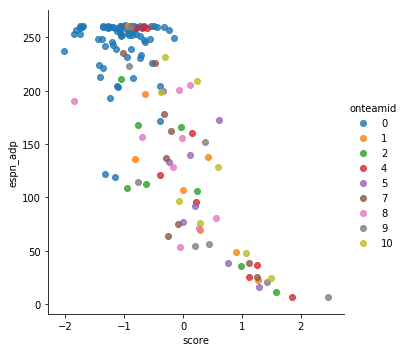

In [26]:
sb.lmplot(x="score", y="espn_adp", hue="onteamid", fit_reg=False, data=dfd[
    (dfd['percentowned'] > 5.0) &
#     ((dfd['claimed'] == 0) | (dfd['onteamid'] == 5)) &
    (dfd['catg'] == 'P') &
    (dfd['injurystatus'] == 'ACTIVE')
].sort_values(by='score', ascending=False).head(150))


In [ ]:
sb.scatterplot(x="score", y="score_ros", hue="score_diff", size="score_diff",
          data=dfd[(dfd['percentowned'] > 20.0) & (dfd['claimed'] == 0) & (dfd['catg'] == 'B')])

Here are the biggest individual differences in ranking for the top 100 players by rank in this system. If the number is negative that means this system thinks that they're better than their espn adp.

In [24]:
dfd[(dfd['percentowned'] > 20.0) & ((dfd['claimed'] == 0) | (dfd['onteamid'] == 5)) & (dfd['pos'] == 'RP')
   ].sort_values(by='score', ascending=False).head(100)

,fullname,claimed,onteamid,eligibility,pos,injurystatus,catg,espn_adp,percentowned,percentstarted,score,rank,shallowest_pos,shallowest_pos_rank,primary_pos,primary_pos_rank,catg_rank
610,Edwin Diaz,1,5,P|RP,RP,ACTIVE,P,92.37,98.48,97.23,0.20825,79.0,RP,1.0,RP,1.0,31.0
634,James Karinchak,1,5,P|RP,RP,ACTIVE,P,132.86,93.50,91.28,-0.23120,135.0,RP,4.0,RP,4.0,54.0
645,Nick Anderson,0,0,P|RP,RP,SIXTY_DAY_DL,P,235.16,55.35,40.27,-0.41225,161.0,RP,7.0,RP,7.0,64.0
694,Giovanny Gallegos,0,0,P|RP,RP,ACTIVE,P,255.65,32.35,24.44,-0.85000,265.0,RP,18.0,RP,18.0,109.0
696,Peter Fairbanks,0,0,P|RP,RP,ACTIVE,P,252.62,20.19,15.84,-0.86190,269.0,RP,20.0,RP,19.0,111.0
703,Diego Castillo,0,0,P|RP,RP,ACTIVE,P,252.18,28.89,22.31,-0.91630,284.0,RP,23.0,RP,22.0,118.0
728,Emilio Pagan,0,0,P|RP,RP,ACTIVE,P,251.48,24.22,18.74,-1.06165,327.0,RP,33.0,RP,31.0,141.0
738,Jordan Hicks,0,0,P|RP,RP,ACTIVE,P,204.31,62.93,52.61,-1.11775,344.0,RP,37.0,RP,35.0,150.0
742,Matt Barnes,0,0,P|RP,RP,ACTIVE,P,238.77,56.83,43.10,-1.14325,348.0,RP,38.0,RP,36.0,154.0
744,Kenley Jansen,0,0,P|RP,RP,ACTIVE,P,119.24,95.17,93.19,-1.16110,353.0,RP,39.0,RP,37.0,156.0


### Team Comparisons

The individual positions and their associated depth for this year.

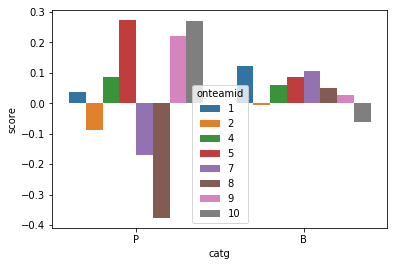

In [32]:
sb.barplot(x="catg", y="score", hue="onteamid", ci=None, data=dfd[dfd['onteamid'] > 0])